In [16]:

# ============================================================
# CELL 0 - PULIZIA RAM E VRAM
# ============================================================
import gc
import torch

def cleanup_memory(extra_names=None):
    """
    Pulisce:
      - riferimenti a modello, dataloader, optimizer, ecc.
      - RAM (gc.collect)
      - VRAM (torch.cuda.empty_cache)
    extra_names: lista opzionale di variabili da cancellare.
    """
    to_delete = [
        "model",
        "model_eval",
        "optimizer",
        "scheduler",
        "criterion",
        "train_loader",
        "val_loader",
        "test_loader",
        "train_ds",
        "val_ds",
        "test_ds",
    ]

    if extra_names is not None:
        to_delete += list(extra_names)

    for name in to_delete:
        if name in globals():
            try:
                del globals()[name]
                # print(f"Deleted: {name}")
            except Exception:
                pass

    # garbage collector (RAM)
    gc.collect()

    # VRAM
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    print("🧹 RAM e VRAM pulite (per quanto possibile senza restart).")

# chiamala così quando vuoi:
cleanup_memory()


🧹 RAM e VRAM pulite (per quanto possibile senza restart).


In [17]:
# ============================================================
# CELL 1 - IMPORTS AND GLOBAL SETUP
# ============================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Reproducibility seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
print("Libraries imported and random seed configured.")


Libraries imported and random seed configured.


In [18]:
# ============================================================
# CELL 2 - CONFIGURATION
# ============================================================

# Dataset locations - MODIFY THESE PATHS
TRAIN_LABELS_PATH = "/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/train_labels.csv"
TRAIN_IMAGES_ROOT = "/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/train/images"
TEST_IMAGES_ROOT  = "/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/test/images"

# <<< NEW: path maschere
TRAIN_MASKS_ROOT = "/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/train/masks"
TEST_MASKS_ROOT  = "/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/test/masks"

# Hyperparameters
IMG_SIZE = 600
BATCH_SIZE = 12
NUM_WORKERS = 2
NUM_CLASSES = 4  # Adjust based on your dataset

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Configuration: IMG_SIZE={IMG_SIZE}, BATCH={BATCH_SIZE}")
print("Running on:", device)


Configuration: IMG_SIZE=600, BATCH=12
Running on: cuda


In [19]:
# ============================================================
# CELL 3 - DATA LOADING AND CLASS WEIGHTS
# ============================================================

# Load training labels
df = pd.read_csv(TRAIN_LABELS_PATH)
print(f"Dataset loaded: {len(df)} total images.")
print(df.head())

# Get column names (adjust based on your CSV structure)
IMG_COL = df.columns[0]  # Usually 'image' or 'filename'
LABEL_COL = df.columns[1]  # Usually 'label' or 'class'

print(f"\nImage column: {IMG_COL}, Label column: {LABEL_COL}")

# Create label mapping (string -> int)
unique_labels = sorted(df[LABEL_COL].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"\nLabel mapping: {label2id}")

# Convert string labels to integers
df['label_id'] = df[LABEL_COL].map(label2id)
LABEL_COL_NUMERIC = 'label_id'

# Class distribution
counts = df[LABEL_COL_NUMERIC].value_counts().sort_index()
print("\nClass distribution:")
for idx, count in counts.items():
    print(f"  {id2label[idx]}: {count}")

# Number of classes
NUM_CLASSES = len(counts)
print(f"\nNumber of classes: {NUM_CLASSES}")

# Loss weights (inverse frequency)
class_counts = counts.values
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * c) for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\nLoss weights: {class_weights_tensor.cpu().numpy()}")


Dataset loaded: 691 total images.
   sample_index            label
0  img_0000.png  Triple negative
1  img_0001.png        Luminal B
2  img_0002.png        Luminal B
3  img_0003.png        Luminal B
4  img_0004.png        Luminal B

Image column: sample_index, Label column: label

Label mapping: {'HER2(+)': 0, 'Luminal A': 1, 'Luminal B': 2, 'Triple negative': 3}

Class distribution:
  HER2(+): 189
  Luminal A: 205
  Luminal B: 220
  Triple negative: 77

Number of classes: 4

Loss weights: [0.91402113 0.8426829  0.7852273  2.2435064 ]


In [20]:
# ============================================================
# CELL 3A - MASK PURGE
# ============================================================
def build_mask_name(img_name: str) -> str:
    base = os.path.basename(str(img_name))
    if base.startswith("img_"):
        return "mask_" + base[len("img_"):]
    else:
        return "mask_" + base

df["img_path"] = df[IMG_COL].apply(lambda x: os.path.join(TRAIN_IMAGES_ROOT, str(x)))
df["mask_path"] = df[IMG_COL].apply(lambda x: os.path.join(TRAIN_MASKS_ROOT, build_mask_name(x)))

# per compatibilità col tuo vecchio codice
df["path"] = df["img_path"]

print("\nEsempio path:")
print(df[[IMG_COL, "img_path", "mask_path"]].head())



Esempio path:
   sample_index                                           img_path  \
0  img_0000.png  /kaggle/input/kagglejson/an2dl_challenge2/an2d...   
1  img_0001.png  /kaggle/input/kagglejson/an2dl_challenge2/an2d...   
2  img_0002.png  /kaggle/input/kagglejson/an2dl_challenge2/an2d...   
3  img_0003.png  /kaggle/input/kagglejson/an2dl_challenge2/an2d...   
4  img_0004.png  /kaggle/input/kagglejson/an2dl_challenge2/an2d...   

                                           mask_path  
0  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
1  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
2  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
3  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
4  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  


In [21]:
# ============================================================
# CELL 3B - MASK QUALITY CHECK (USANDO tissue_mask_hsv)
# ============================================================
!cp /kaggle/input/kagglejson/shrek_and_bug_detector.py .

import cv2
from tqdm import tqdm
from shrek_and_bug_detector import tissue_mask_hsv

def img_path_to_mask_path(img_path):
    base = os.path.basename(img_path)     # img_0000.png
    mask_name = base.replace("img_", "mask_")
    return os.path.join(TRAIN_MASKS_ROOT, mask_name)

def compute_mask_tissue_overlap_row(img_path):
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        return {
            "frac_mask_on_tissue": np.nan,
            "frac_tissue_covered": np.nan,
            "iou_mask_tissue": np.nan,
        }
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    mask_path = img_path_to_mask_path(img_path)
    if not os.path.exists(mask_path):
        return {
            "frac_mask_on_tissue": np.nan,
            "frac_tissue_covered": np.nan,
            "iou_mask_tissue": np.nan,
        }

    mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask_gray is None:
        return {
            "frac_mask_on_tissue": np.nan,
            "frac_tissue_covered": np.nan,
            "iou_mask_tissue": np.nan,
        }

    mask_bin = mask_gray > 0

    H, S, V, tissue = tissue_mask_hsv(img_rgb)   # tissue: bool

    if tissue.shape != mask_bin.shape:
        h = min(tissue.shape[0], mask_bin.shape[0])
        w = min(tissue.shape[1], mask_bin.shape[1])
        tissue   = tissue[:h, :w]
        mask_bin = mask_bin[:h, :w]

    inter      = (mask_bin & tissue).sum()
    union      = (mask_bin | tissue).sum()
    mask_sum   = mask_bin.sum()
    tissue_sum = tissue.sum()

    if mask_sum == 0 or tissue_sum == 0:
        frac_mask_on_tissue = np.nan
        frac_tissue_covered = np.nan
        iou = np.nan
    else:
        frac_mask_on_tissue = inter / mask_sum
        frac_tissue_covered = inter / tissue_sum
        iou = inter / union if union > 0 else np.nan

    return {
        "frac_mask_on_tissue": float(frac_mask_on_tissue),
        "frac_tissue_covered": float(frac_tissue_covered),
        "iou_mask_tissue": float(iou),
    }

# ---- calcolo su tutto il df ----
overlap_rows = []
for p in tqdm(df["img_path"], total=len(df)):
    metrics = compute_mask_tissue_overlap_row(p)
    metrics["img_path"] = p
    overlap_rows.append(metrics)

print("\nPreview df_overlap:")
df_overlap = pd.DataFrame(overlap_rows)
print(df_overlap.head())

# ---- PULIZIA COLONNE VECCHIE NEL df ----
metric_substrings = ["frac_mask_on_tissue", "frac_tissue_covered", "iou_mask_tissue"]

cols_to_drop = [c for c in df.columns if any(s in c for s in metric_substrings)]
print("\nDroppo dal df queste colonne metriche vecchie:", cols_to_drop)
df = df.drop(columns=cols_to_drop, errors="ignore")

# ---- MERGE PULITO ----
df = df.merge(df_overlap, on="img_path", how="left")

# ---- THRESHOLD DOPPI ----
THR_FRAC  = 0.70   # % della MASCHERA che deve stare su tessuto
THR_COVER = 0.05   # % del TESSUTO che deve essere coperto dalla mask

df["mask_ok"] = (
    (df["frac_mask_on_tissue"] >= THR_FRAC) &
    (df["frac_tissue_covered"] >= THR_COVER)
)

print(f"\nImmagini con mask sotto soglia (frac<{THR_FRAC} o cover<{THR_COVER}):",
      (~df["mask_ok"]).sum())
print("Immagini con mask_ok True:", df["mask_ok"].sum())

print("\nDistribuzione label nelle righe SCARTATE:")
print(df.loc[~df["mask_ok"], LABEL_COL_NUMERIC].value_counts().sort_index())

# dataframe pulito
df_clean = df[df["mask_ok"]].reset_index(drop=True)
print("\nDopo filtro mask_ok:")
print("Righe df_clean:", len(df_clean))
print(df_clean[LABEL_COL_NUMERIC].value_counts().sort_index())

  3%|▎         | 20/691 [00:00<00:17, 38.08it/s][ WARN:0@481.396] global loadsave.cpp:275 findDecoder imread_('/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/train/images/img_0020.png'): can't open/read file: check file path/integrity
[ WARN:0@481.435] global loadsave.cpp:275 findDecoder imread_('/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/train/images/img_0022.png'): can't open/read file: check file path/integrity
  4%|▎         | 25/691 [00:00<00:16, 40.31it/s][ WARN:0@481.574] global loadsave.cpp:275 findDecoder imread_('/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/train/images/img_0027.png'): can't open/read file: check file path/integrity
[ WARN:0@481.574] global loadsave.cpp:275 findDecoder imread_('/kaggle/input/kagglejson/an2dl_challenge2/an2dl_challenge2/train/images/img_0028.png'): can't open/read file: check file path/integrity
  7%|▋         | 45/691 [00:01<00:17, 37.92it/s][ WARN:0@482.043] global loadsave.cpp:275 findDecoder imread


Preview df_overlap:
   frac_mask_on_tissue  frac_tissue_covered  iou_mask_tissue  \
0             0.970964             0.036803         0.036763   
1                  NaN                  NaN              NaN   
2             0.996512             0.043455         0.043448   
3             0.757062             0.113384         0.109403   
4             0.947271             0.040670         0.040578   

                                            img_path  
0  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
1  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
2  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
3  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  
4  /kaggle/input/kagglejson/an2dl_challenge2/an2d...  

Droppo dal df queste colonne metriche vecchie: []

Immagini con mask sotto soglia (frac<0.7 o cover<0.05): 242
Immagini con mask_ok True: 449

Distribuzione label nelle righe SCARTATE:
label_id
0    72
1    85
2    59
3    26
Name: count, dtype: int64

Dopo filtr


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)


In [22]:
# dopo aver creato df_clean
base_df = df_clean.copy()

# Class distribution (RICALCOLA DA df_clean)
counts = base_df[LABEL_COL_NUMERIC].value_counts().sort_index()
print("\nClass distribution (dopo filtro maschere):")
for idx, count in counts.items():
    print(f"  {id2label[idx]}: {count}")

NUM_CLASSES = len(counts)
print(f"\nNumber of classes: {NUM_CLASSES}")

class_counts = counts.values
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * c) for c in class_counts]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\nLoss weights: {class_weights_tensor.cpu().numpy()}")



Class distribution (dopo filtro maschere):
  HER2(+): 117
  Luminal A: 120
  Luminal B: 161
  Triple negative: 51

Number of classes: 4

Loss weights: [0.9594017  0.93541664 0.69720495 2.2009804 ]


In [23]:
# ============================================================
# CELL 3C - CROPPING IMAGE TO MASK
# ============================================================

def crop_to_mask(img, mask, pad=20):
    """
    img: np.array (H, W, 3)
    mask: np.array (H, W) oppure None
    """
    if mask is None:
        return img, mask

    mask_bin = mask > 0
    ys, xs = np.where(mask_bin)

    if len(xs) == 0:
        # nessun pixel di maschera -> non croppare
        return img, mask

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    y1 = max(y1 - pad, 0)
    x1 = max(x1 - pad, 0)
    y2 = min(y2 + pad, mask.shape[0] - 1)
    x2 = min(x2 + pad, mask.shape[1] - 1)

    img_crop  = img[y1:y2+1, x1:x2+1, :]
    mask_crop = mask[y1:y2+1, x1:x2+1]

    return img_crop, mask_crop


In [24]:
# ============================================================
# CELL 4 - DATASET AND DATALOADER
# ============================================================
# dopo aver creato df_clean

class ImageDataset(Dataset):
    def __init__(self, df, img_col, label_col, root="", mask_root=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.label_col = label_col
        self.root = root
        self.mask_root = mask_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = str(self.df.loc[idx, self.img_col])
        img_path = os.path.join(self.root, img_name)
        label = int(self.df.loc[idx, self.label_col])

        # --- immagine ---
        try:
            pil_img = Image.open(img_path).convert("RGB")
            img_np = np.array(pil_img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img_np = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

        # --- maschera ---
        mask_np = None
        if self.mask_root is not None:
            base = os.path.basename(img_name)
            if base.startswith("img_"):
                mask_name = "mask_" + base[len("img_"):]
            else:
                mask_name = "mask_" + base

            mask_path = os.path.join(self.mask_root, mask_name)

            try:
                mask_pil = Image.open(mask_path).convert("L")
                mask_np = np.array(mask_pil)
            except Exception:
                mask_np = np.zeros(img_np.shape[:2], dtype=np.uint8)
        else:
            mask_np = np.zeros(img_np.shape[:2], dtype=np.uint8)

        # --- crop sulla mask ---
        img_np, mask_np = crop_to_mask(img_np, mask_np, pad=20)

        # --- transform congiunta ---
        if self.transform:
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented["image"]      # (3,H,W)
            mask = augmented["mask"]      # (H,W)
        else:
            img = T.ToTensor()(Image.fromarray(img_np))
            mask = torch.zeros(img.shape[1:], dtype=torch.float32)

        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)

        mask = (mask > 0).float()
        mask = mask.unsqueeze(0)          # (1,H,W)
        img = torch.cat([img, mask], dim=0)  # (4,H,W)

        return img, label


class TestDataset(Dataset):
    def __init__(self, root, mask_root=None, transform=None):
        self.root = root
        self.mask_root = mask_root
        self.transform = transform
        self.image_files = sorted([
            f for f in os.listdir(root)
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
            and f.startswith("img_")
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root, img_name)

        # --- immagine ---
        try:
            pil_img = Image.open(img_path).convert("RGB")
            img_np = np.array(pil_img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            img_np = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

        # --- maschera ---
        mask_np = None
        if self.mask_root is not None:
            base = os.path.basename(img_name)
            if base.startswith("img_"):
                mask_name = "mask_" + base[len("img_"):]
            else:
                mask_name = "mask_" + base

            mask_path = os.path.join(self.mask_root, mask_name)

            try:
                mask_pil = Image.open(mask_path).convert("L")
                mask_np = np.array(mask_pil)
            except Exception:
                mask_np = np.zeros(img_np.shape[:2], dtype=np.uint8)
        else:
            mask_np = np.zeros(img_np.shape[:2], dtype=np.uint8)

        # --- crop sulla mask ---
        img_np, mask_np = crop_to_mask(img_np, mask_np, pad=20)

        # --- transform congiunta ---
        if self.transform:
            augmented = self.transform(image=img_np, mask=mask_np)
            img = augmented["image"]
            mask = augmented["mask"]
        else:
            img = T.ToTensor()(Image.fromarray(img_np))
            mask = torch.zeros(img.shape[1:], dtype=torch.float32)

        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask)

        mask = (mask > 0).float()
        mask = mask.unsqueeze(0)
        img = torch.cat([img, mask], dim=0)

        return img, img_name


# Transformations - Ottimizzate per WSI
from albumentations.core.transforms_interface import ImageOnlyTransform

class TorchRandAugment(ImageOnlyTransform):
    def __init__(self, num_ops=2, magnitude=7, p=0.7):
        super().__init__(p=p)
        self.ra = T.RandAugment(num_ops=num_ops, magnitude=magnitude)

    def apply(self, img, **params):
        # img è un numpy array (H,W,3) in uint8
        pil_img = Image.fromarray(img)
        pil_img = self.ra(pil_img)
        img_out = np.array(pil_img)
        return img_out

train_transform = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),

        # AUTOMATED AUGMENTATION
        TorchRandAugment(num_ops=2, magnitude=7, p=0.7),

        # (opzionale) qualche cosa molto soft extra
        A.Rotate(limit=10, border_mode=0, p=0.3),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        A.RandomBrightnessContrast(
            brightness_limit=0.12, contrast_limit=0.12, p=0.5
        ),
        A.HueSaturationValue(
            hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.4
        ),

        A.GaussNoise(p=0.2),
        A.GaussianBlur(blur_limit=(3, 3), p=0.15),

        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ],
    additional_targets={'mask': 'mask'}
)



val_transform = A.Compose(
    [
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ],
    additional_targets={'mask': 'mask'}
)

# ============================================================
# SPLIT + DATALOADERS
# ============================================================
from torch.utils.data import DataLoader, WeightedRandomSampler

# se per qualche motivo non hai fatto il check, fallback su df
base_df = df_clean

train_df, val_df = train_test_split(
    base_df,
    stratify=base_df[LABEL_COL_NUMERIC],
    test_size=0.2,
    random_state=SEED
)


print("Train size (prima oversampling):", len(train_df), "Val size:", len(val_df))

# ---- OVERSAMPLING CLASSE 3 SOLO NEL TRAIN ----

#minority = train_df[train_df[LABEL_COL_NUMERIC] == 3]
# duplichi 2 volte la classe 3 (puoi cambiare il numero di concat)
#train_df = pd.concat([train_df, minority, minority], ignore_index=True)
#train_df = train_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

#print("Train size (dopo oversampling classe 3):", len(train_df))
#print("Distribuzione train oversampled:")
#print(train_df[LABEL_COL_NUMERIC].value_counts().sort_index())

train_ds = ImageDataset(
    train_df,
    IMG_COL,
    LABEL_COL_NUMERIC,
    root=TRAIN_IMAGES_ROOT,
    mask_root=TRAIN_MASKS_ROOT,
    transform=train_transform
)

val_ds = ImageDataset(
    val_df,
    IMG_COL,
    LABEL_COL_NUMERIC,
    root=TRAIN_IMAGES_ROOT,
    mask_root=TRAIN_MASKS_ROOT,
    transform=val_transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False
)

print("DataLoaders initialized (mask filter + weighted sampler).")



Train size (prima oversampling): 359 Val size: 90
DataLoaders initialized (mask filter + weighted sampler).


In [25]:
# ============================================================
# CELL 4.5 - LOSS DEFINITION AND TTA TESTS
# ============================================================
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.5, reduction="mean"):
        super().__init__()
        self.alpha = alpha  # tensor [num_classes] o None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.alpha, reduction="none")  # [B]
        probs = F.softmax(logits, dim=1)
        pt = probs[torch.arange(len(targets)), targets]
        loss = ((1 - pt) ** self.gamma) * ce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

def tta_predict(inputs_4ch, model):
    """
    inputs_4ch: tensor (1,4,H,W) già normalizzato
    ritorna: pred, probs_mean (np.array)
    """
    x   = inputs_4ch
    x_h = torch.flip(x, dims=[3])        # flip orizzontale
    x_v = torch.flip(x, dims=[2])        # flip verticale
    x_hv= torch.flip(x, dims=[2, 3])     # flip entrambe

    batch = torch.cat([x, x_h, x_v, x_hv], dim=0).to(device)  # (4,4,H,W)

    with torch.no_grad():
        logits = model(batch)
        probs  = torch.softmax(logits, dim=1)
        probs_mean = probs.mean(dim=0)   # (num_classes,)

    pred = probs_mean.argmax().item()
    return pred, probs_mean.cpu().numpy()


In [26]:
# ============================================================
# CELL 5 - MODEL DEFINITION
# ============================================================

def get_model():
    print("Loading EfficientNet-B7 weights...")
    weights = models.EfficientNet_B7_Weights.DEFAULT
    model = models.efficientnet_b7(weights=weights)

    # <<< NEW: porta il primo conv da 3 canali a 4 (RGB + mask)
    first_conv = model.features[0][0]  # Conv2d(3, ...)
    in_channels_old = first_conv.in_channels
    out_channels = first_conv.out_channels
    kernel_size = first_conv.kernel_size
    stride = first_conv.stride
    padding = first_conv.padding
    bias = first_conv.bias is not None

    new_conv = nn.Conv2d(
        in_channels=4,  # <<< 4 canali
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        bias=bias
    )

    # copia i pesi dei 3 canali RGB, inizializza il 4° con la media
    with torch.no_grad():
        new_conv.weight[:, :3, :, :] = first_conv.weight
        new_conv.weight[:, 3:4, :, :] = first_conv.weight.mean(dim=1, keepdim=True)
        if bias:
            new_conv.bias[:] = first_conv.bias

    model.features[0][0] = new_conv  # sostituisci

    in_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(512, NUM_CLASSES)
    )

    for param in model.parameters():
        param.requires_grad = True

    return model

model = get_model()

if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs detected. Enabling DataParallel.")
    model = nn.DataParallel(model)

model = model.to(device)
print("Model ready.")


Loading EfficientNet-B7 weights...
2 GPUs detected. Enabling DataParallel.
Model ready.


In [12]:
# ============================================================
# CELL X - INSTALLAZIONE OPTIMIZER MODERNI
# ============================================================
#!pip install -q lion-pytorch git+https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer.git


In [27]:
from tqdm import tqdm

# ============================================================
# CELL 6: TRAIN LOOP
# ============================================================

def train_one_epoch(model, loader, criterion, optimizer, epoch_idx, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Train {epoch_idx+1}/{total_epochs}", ncols=90)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=loss.item())

    return running_loss / total, correct / total


from sklearn.metrics import balanced_accuracy_score, f1_score

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true, y_pred = [], []

    pbar = tqdm(loader, desc="Valid", ncols=90)

    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            pbar.set_postfix(loss=loss.item())

    val_loss = running_loss / total
    val_acc = correct / total
    val_bal_acc = balanced_accuracy_score(y_true, y_pred)
    val_f1_macro = f1_score(y_true, y_pred, average="macro")

    return val_loss, val_acc, val_bal_acc, val_f1_macro


## Analysis PITSTOP

In [14]:
# ============================================================
# CELL X - FIND HIGH-LOSS TRAIN SAMPLES
# ============================================================

import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# usa lo stesso Dataset usato per il training, ma SENZA augment forti
train_ds_eval = ImageDataset(
    train_df,
    IMG_COL,
    LABEL_COL_NUMERIC,
    root=TRAIN_IMAGES_ROOT,
    mask_root=TRAIN_MASKS_ROOT,
    transform=val_transform
)

train_loader_eval = DataLoader(
    train_ds_eval,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

model.to(device)
model.eval()


criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


all_losses = []
all_indices = []

with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader_eval)):
        imgs   = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        losses  = criterion_per_sample(outputs, labels)  # [B]

        all_losses.extend(losses.cpu().tolist())
        # tieni traccia dell’indice globale nel df
        start_idx = batch_idx * train_loader_eval.batch_size
        idxs = list(range(start_idx, start_idx + imgs.size(0)))
        all_indices.extend(idxs)

# DataFrame con loss per sample
df_loss = pd.DataFrame({
    "df_index": all_indices,
    "loss": all_losses
})

df_loss_sorted = df_loss.sort_values("loss", ascending=False)
TOP_K = 50
df_topk = df_loss_sorted.head(TOP_K)

# unisci con info originali (path, label, ecc.)

df_train = train_df  # una volta sopra

df_topk_merged = df_topk.merge(
    df_train.reset_index().rename(columns={"index": "df_index"}),
    on="df_index",
    how="left"
)

df_topk_merged.to_csv("train_high_loss_samples.csv", index=False)
print("Salvato train_high_loss_samples.csv")


  0%|          | 0/30 [00:02<?, ?it/s]


NameError: name 'criterion_per_sample' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# ===============================
# PATH DA MODIFICARE A PIACERE
# ===============================
IMG_PATH  = "/kaggle/input/kagglejson/an2dl_challenge2_1000/an2dl_challenge2_1000/train/images/img_0726.png"
MASK_PATH = "/kaggle/input/kagglejson/an2dl_challenge2_1000/an2dl_challenge2_1000/train/masks/mask_0726.png"

# ===============================
# VERSIONE CORRETTA DI crop_to_mask
# ===============================
def crop_to_mask(img, mask, pad=20):
    mask_bin = mask > 0
    ys, xs = np.where(mask_bin)

    if len(xs) == 0:
        return img, mask

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    y1 = max(y1 - pad, 0)
    x1 = max(x1 - pad, 0)
    y2 = min(y2 + pad, mask.shape[0]-1)
    x2 = min(x2 + pad, mask.shape[1]-1)

    img_crop  = img[y1:y2+1, x1:x2+1, :]
    mask_crop = mask[y1:y2+1, x1:x2+1]

    return img_crop, mask_crop


# ===============================
# LETTURA IMG E MASK
# ===============================
orig_img  = np.array(Image.open(IMG_PATH).convert("RGB"))
orig_mask = np.array(Image.open(MASK_PATH).convert("L"))

img_crop, mask_crop = crop_to_mask(orig_img, orig_mask, pad=15)

# ===============================
# PLOT
# ===============================
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.title("Immagine originale")
plt.imshow(orig_img)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Mask originale")
plt.imshow(orig_mask, cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("CROP — immagine")
plt.imshow(img_crop)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("CROP — mask")
plt.imshow(mask_crop, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

print("Original shape:", orig_img.shape, "   Cropped shape:", img_crop.shape)


## TTTRRRAINING

In [28]:
# ============================================================
# CELL 6B - MAIN TRAINING LOOP
#      (BACKBONE SEMPRE FREEZATO, LION/RANGER + SCHEDULE)
# ============================================================

import torch
import torch.nn as nn
import math

from lion_pytorch import Lion
from ranger import Ranger
from torch.optim.lr_scheduler import CosineAnnealingLR

# ------------------------------------------------------------
# 1) HYPERPARAMS
# ------------------------------------------------------------

EPOCHS            = 80

BASE_LR_backbone  = 1e-5
BASE_LR_head      = 5e-4        # lr "definitivo" per la head
BASE_WEIGHT_DECAY = 1e-2

PATIENCE  = 15
MIN_DELTA = 0.0

# scegli: "lion" oppure "ranger"
OPTIMIZER_NAME = "ranger"   # "lion" / "ranger"

# ------------------------------------------------------------
# 2) ADJUST PER OPTIMIZER (Lion vs Ranger)
# ------------------------------------------------------------

if OPTIMIZER_NAME.lower() == "lion":
    # Paper + repo: lr ≈ 3x più piccolo, wd ≈ 3x più grande
    LR_backbone  = BASE_LR_backbone  / 3.0
    LR_head      = BASE_LR_head      / 3.0
    WEIGHT_DECAY = BASE_WEIGHT_DECAY * 3.0

    LION_BETAS = (0.95, 0.98)

elif OPTIMIZER_NAME.lower() == "ranger":
    # Ranger: lr simili ad AdamW
    LR_backbone  = BASE_LR_backbone
    LR_head      = BASE_LR_head
    WEIGHT_DECAY = BASE_WEIGHT_DECAY

    RANGER_BETAS = (0.95, 0.999)

else:
    # fallback: AdamW style
    LR_backbone  = BASE_LR_backbone
    LR_head      = BASE_LR_head
    WEIGHT_DECAY = BASE_WEIGHT_DECAY

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# ------------------------------------------------------------
# 3) SEPARA BACKBONE E HEAD (gestendo DataParallel)
# ------------------------------------------------------------
if isinstance(model, nn.DataParallel):
    backbone = model.module.features
    head     = model.module.classifier
else:
    backbone = model.features
    head     = model.classifier

# ------------------------------------------------------------
# 4) FREEZE BATCHNORM (dataset piccolo)
# ------------------------------------------------------------
def set_bn_eval(m):
    if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        m.eval()

model.apply(set_bn_eval)

# ------------------------------------------------------------
# 5) BACKBONE SEMPRE FREEZATO
# ------------------------------------------------------------
for p in backbone.parameters():
    p.requires_grad = False
for p in head.parameters():
    p.requires_grad = True

# ------------------------------------------------------------
# 6) CREAZIONE OPTIMIZER (BACKBONE FREEZATO, MA PARAM_GROUP PRESENTE)
# ------------------------------------------------------------
def create_optimizer(optimizer_name, backbone_params, head_params):
    name = optimizer_name.lower()
    param_groups = [
        {"params": backbone_params, "lr": LR_backbone},
        {"params": head_params,     "lr": LR_head},
    ]

    if name == "lion":
        return Lion(
            param_groups,
            lr=LR_head,
            betas=LION_BETAS,
            weight_decay=WEIGHT_DECAY,
        )
    elif name == "ranger":
        return Ranger(
            param_groups,
            lr=LR_head,
            betas=RANGER_BETAS,
            weight_decay=WEIGHT_DECAY,
        )
    else:
        return torch.optim.AdamW(
            param_groups,
            weight_decay=WEIGHT_DECAY,
        )

optimizer = create_optimizer(OPTIMIZER_NAME, backbone.parameters(), head.parameters())

# ------------------------------------------------------------
# 7) SCHEDULE
#    - Lion: Cosine su tutti gli epoch
#    - Ranger: 75% flat + 25% cosine, su tutti gli epoch
# ------------------------------------------------------------
def update_ranger_lr(optimizer, epoch, total_epochs,
                     base_lrs, min_factor=0.1):
    """
    75% epoche flat, 25% cosine decay sulle lr di base.
    base_lrs = [lr_backbone, lr_head]
    """
    full_epochs = total_epochs
    if full_epochs <= 0:
        return

    # indice epoca 0-based
    full_idx = epoch

    flat_epochs = int(0.75 * full_epochs)
    if full_idx < flat_epochs:
        factor = 1.0
    else:
        denom = max(1, full_epochs - flat_epochs)
        t = (full_idx - flat_epochs) / denom
        factor = min_factor + 0.5 * (1 - min_factor) * (1 + math.cos(math.pi * t))

    for pg, base_lr in zip(optimizer.param_groups, base_lrs):
        pg["lr"] = base_lr * factor

if OPTIMIZER_NAME.lower() == "lion":
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=EPOCHS,
        eta_min=0.0,
    )
else:
    scheduler = None
    ranger_base_lrs = [LR_backbone, LR_head] if OPTIMIZER_NAME.lower() == "ranger" else None

# ------------------------------------------------------------
# 8) LOGGING
# ------------------------------------------------------------
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_bal_acc": [],
    "val_f1_macro": [],
}

best_val_f1       = -math.inf
best_epoch        = -1
epochs_no_improve = 0

# ------------------------------------------------------------
# 9) MAIN LOOP (BACKBONE SEMPRE FREEZATO)
# ------------------------------------------------------------
for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ({OPTIMIZER_NAME}) ===")

    # ---- TRAIN ----
    train_loss, train_acc = train_one_epoch(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        epoch_idx=epoch,
        total_epochs=EPOCHS,
    )

    # ---- VALIDATION ----
    val_loss, val_acc, val_bal_acc, val_f1 = validate(
        model=model,
        loader=val_loader,
        criterion=criterion,
    )

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_bal_acc"].append(val_bal_acc)
    history["val_f1_macro"].append(val_f1)

    print(
        f"Train - loss: {train_loss:.4f} | acc: {train_acc:.4f}\n"
        f"Valid - loss: {val_loss:.4f} | acc: {val_acc:.4f} | "
        f"bal_acc: {val_bal_acc:.4f} | f1_macro: {val_f1:.4f}"
    )

    # ---- SCHEDULE STEP ----
    if OPTIMIZER_NAME.lower() == "lion" and scheduler is not None:
        scheduler.step()
    elif OPTIMIZER_NAME.lower() == "ranger" and ranger_base_lrs is not None:
        update_ranger_lr(
            optimizer,
            epoch=epoch,
            total_epochs=EPOCHS,
            base_lrs=ranger_base_lrs,
            min_factor=0.1,
        )

    # ---- CHECKPOINT + EARLY STOPPING (su F1 macro) ----
    if val_f1 > best_val_f1 + MIN_DELTA:
        best_val_f1 = val_f1
        best_epoch  = epoch
        epochs_no_improve = 0

        ckpt_name = f"best_effnet_b7_mask_f1_{OPTIMIZER_NAME}.pth"
        torch.save(model.state_dict(), ckpt_name)
        print(f"✅ New best model saved (val F1 macro = {best_val_f1:.4f} at epoch {epoch+1})")
    else:
        epochs_no_improve += 1
        print(
            f"⚠️ No improvement in F1 for {epochs_no_improve} epoch(s) "
            f"(best = {best_val_f1:.4f} at epoch {best_epoch+1})"
        )

        if epochs_no_improve >= PATIENCE:
            print(f"\n🛑 Early stopping triggered after {PATIENCE} epochs without improvement.")
            break

print(f"\nTraining finished. Best epoch: {best_epoch+1} | best val F1 macro: {best_val_f1:.4f}")

# ricarico il best model per sicurezza
ckpt_name = f"best_effnet_b7_mask_f1_{OPTIMIZER_NAME}.pth"
model.load_state_dict(torch.load(ckpt_name))
model_eval = model.eval()


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers

=== Epoch 1/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s, loss=1.32]


Train - loss: 1.4469 | acc: 0.2902
Valid - loss: 1.3806 | acc: 0.3000 | bal_acc: 0.2500 | f1_macro: 0.2032
✅ New best model saved (val F1 macro = 0.2032 at epoch 1)

=== Epoch 2/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=1.26]


Train - loss: 1.4007 | acc: 0.3305
Valid - loss: 1.3927 | acc: 0.2889 | bal_acc: 0.2344 | f1_macro: 0.1958
⚠️ No improvement in F1 for 1 epoch(s) (best = 0.2032 at epoch 1)

=== Epoch 3/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=1.28]


Train - loss: 1.3992 | acc: 0.2989
Valid - loss: 1.3752 | acc: 0.3222 | bal_acc: 0.2870 | f1_macro: 0.2721
✅ New best model saved (val F1 macro = 0.2721 at epoch 3)

=== Epoch 4/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.48it/s, loss=1.28]


Train - loss: 1.3974 | acc: 0.3448
Valid - loss: 1.3602 | acc: 0.2889 | bal_acc: 0.2911 | f1_macro: 0.2907
✅ New best model saved (val F1 macro = 0.2907 at epoch 4)

=== Epoch 5/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.54it/s, loss=1.27]


Train - loss: 1.3515 | acc: 0.3333
Valid - loss: 1.3449 | acc: 0.3667 | bal_acc: 0.3786 | f1_macro: 0.3642
✅ New best model saved (val F1 macro = 0.3642 at epoch 5)

=== Epoch 6/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.63it/s, loss=1.26]


Train - loss: 1.3322 | acc: 0.3736
Valid - loss: 1.3521 | acc: 0.3778 | bal_acc: 0.3745 | f1_macro: 0.3482
⚠️ No improvement in F1 for 1 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 7/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s, loss=1.28]


Train - loss: 1.3681 | acc: 0.3017
Valid - loss: 1.3529 | acc: 0.3333 | bal_acc: 0.3406 | f1_macro: 0.3056
⚠️ No improvement in F1 for 2 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 8/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s, loss=1.25]


Train - loss: 1.3370 | acc: 0.3362
Valid - loss: 1.3487 | acc: 0.3556 | bal_acc: 0.3854 | f1_macro: 0.3506
⚠️ No improvement in F1 for 3 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 9/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=1.23]


Train - loss: 1.3330 | acc: 0.3391
Valid - loss: 1.3339 | acc: 0.3778 | bal_acc: 0.3917 | f1_macro: 0.3526
⚠️ No improvement in F1 for 4 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 10/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s, loss=1.24]


Train - loss: 1.3047 | acc: 0.3937
Valid - loss: 1.3118 | acc: 0.3778 | bal_acc: 0.3771 | f1_macro: 0.3504
⚠️ No improvement in F1 for 5 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 11/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s, loss=1.29]


Train - loss: 1.3052 | acc: 0.3621
Valid - loss: 1.3130 | acc: 0.3444 | bal_acc: 0.3458 | f1_macro: 0.3263
⚠️ No improvement in F1 for 6 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 12/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=1.34]


Train - loss: 1.3281 | acc: 0.3477
Valid - loss: 1.3371 | acc: 0.3556 | bal_acc: 0.3510 | f1_macro: 0.3386
⚠️ No improvement in F1 for 7 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 13/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s, loss=1.28]


Train - loss: 1.3107 | acc: 0.3678
Valid - loss: 1.3434 | acc: 0.3444 | bal_acc: 0.3578 | f1_macro: 0.3409
⚠️ No improvement in F1 for 8 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 14/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s, loss=1.26]


Train - loss: 1.2568 | acc: 0.4080
Valid - loss: 1.3552 | acc: 0.3000 | bal_acc: 0.3068 | f1_macro: 0.2966
⚠️ No improvement in F1 for 9 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 15/80 (ranger) ===


Valid: 100%|██████████████████████████████████████| 8/8 [00:05<00:00,  1.56it/s, loss=1.3]


Train - loss: 1.3258 | acc: 0.3621
Valid - loss: 1.3491 | acc: 0.3444 | bal_acc: 0.3380 | f1_macro: 0.3327
⚠️ No improvement in F1 for 10 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 16/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.56it/s, loss=1.24]


Train - loss: 1.2951 | acc: 0.3621
Valid - loss: 1.3261 | acc: 0.3778 | bal_acc: 0.3693 | f1_macro: 0.3572
⚠️ No improvement in F1 for 11 epoch(s) (best = 0.3642 at epoch 5)

=== Epoch 17/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=1.24]


Train - loss: 1.2516 | acc: 0.4511
Valid - loss: 1.3010 | acc: 0.4000 | bal_acc: 0.4099 | f1_macro: 0.3880
✅ New best model saved (val F1 macro = 0.3880 at epoch 17)

=== Epoch 18/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=1.26]


Train - loss: 1.2836 | acc: 0.3793
Valid - loss: 1.3056 | acc: 0.3778 | bal_acc: 0.3891 | f1_macro: 0.3708
⚠️ No improvement in F1 for 1 epoch(s) (best = 0.3880 at epoch 17)

=== Epoch 19/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.67it/s, loss=1.37]


Train - loss: 1.2973 | acc: 0.4052
Valid - loss: 1.3238 | acc: 0.3889 | bal_acc: 0.3995 | f1_macro: 0.3759
⚠️ No improvement in F1 for 2 epoch(s) (best = 0.3880 at epoch 17)

=== Epoch 20/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.63it/s, loss=1.37]


Train - loss: 1.2796 | acc: 0.3764
Valid - loss: 1.3102 | acc: 0.3667 | bal_acc: 0.3812 | f1_macro: 0.3600
⚠️ No improvement in F1 for 3 epoch(s) (best = 0.3880 at epoch 17)

=== Epoch 21/80 (ranger) ===


Valid: 100%|██████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s, loss=1.3]


Train - loss: 1.2824 | acc: 0.4080
Valid - loss: 1.3043 | acc: 0.4111 | bal_acc: 0.4203 | f1_macro: 0.3966
✅ New best model saved (val F1 macro = 0.3966 at epoch 21)

=== Epoch 22/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s, loss=1.27]


Train - loss: 1.2689 | acc: 0.4052
Valid - loss: 1.3169 | acc: 0.3778 | bal_acc: 0.4115 | f1_macro: 0.3699
⚠️ No improvement in F1 for 1 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 23/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s, loss=1.34]


Train - loss: 1.2007 | acc: 0.4253
Valid - loss: 1.3328 | acc: 0.3000 | bal_acc: 0.3385 | f1_macro: 0.3049
⚠️ No improvement in F1 for 2 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 24/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=1.39]


Train - loss: 1.2496 | acc: 0.3908
Valid - loss: 1.3497 | acc: 0.2778 | bal_acc: 0.3083 | f1_macro: 0.2710
⚠️ No improvement in F1 for 3 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 25/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.62it/s, loss=1.35]


Train - loss: 1.2088 | acc: 0.4368
Valid - loss: 1.3236 | acc: 0.3000 | bal_acc: 0.3505 | f1_macro: 0.3055
⚠️ No improvement in F1 for 4 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 26/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s, loss=1.21]


Train - loss: 1.2694 | acc: 0.4109
Valid - loss: 1.3004 | acc: 0.3778 | bal_acc: 0.4156 | f1_macro: 0.3692
⚠️ No improvement in F1 for 5 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 27/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.53it/s, loss=1.14]


Train - loss: 1.2358 | acc: 0.4425
Valid - loss: 1.2907 | acc: 0.3667 | bal_acc: 0.3984 | f1_macro: 0.3649
⚠️ No improvement in F1 for 6 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 28/80 (ranger) ===


Valid: 100%|██████████████████████████████████████| 8/8 [00:05<00:00,  1.51it/s, loss=1.2]


Train - loss: 1.2135 | acc: 0.4138
Valid - loss: 1.3013 | acc: 0.3000 | bal_acc: 0.3266 | f1_macro: 0.2733
⚠️ No improvement in F1 for 7 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 29/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.66it/s, loss=1.22]


Train - loss: 1.2570 | acc: 0.4195
Valid - loss: 1.3398 | acc: 0.3111 | bal_acc: 0.3292 | f1_macro: 0.2893
⚠️ No improvement in F1 for 8 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 30/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.63it/s, loss=1.22]


Train - loss: 1.2009 | acc: 0.4339
Valid - loss: 1.3710 | acc: 0.3111 | bal_acc: 0.3292 | f1_macro: 0.3017
⚠️ No improvement in F1 for 9 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 31/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.64it/s, loss=1.15]


Train - loss: 1.2217 | acc: 0.4425
Valid - loss: 1.3508 | acc: 0.3111 | bal_acc: 0.3344 | f1_macro: 0.2979
⚠️ No improvement in F1 for 10 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 32/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.68it/s, loss=1.09]


Train - loss: 1.2294 | acc: 0.4339
Valid - loss: 1.3365 | acc: 0.3222 | bal_acc: 0.3568 | f1_macro: 0.3231
⚠️ No improvement in F1 for 11 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 33/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.55it/s, loss=1.07]


Train - loss: 1.2493 | acc: 0.4080
Valid - loss: 1.3254 | acc: 0.3889 | bal_acc: 0.3969 | f1_macro: 0.3779
⚠️ No improvement in F1 for 12 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 34/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s, loss=1.08]


Train - loss: 1.2767 | acc: 0.4138
Valid - loss: 1.3460 | acc: 0.3889 | bal_acc: 0.3943 | f1_macro: 0.3816
⚠️ No improvement in F1 for 13 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 35/80 (ranger) ===


Valid: 100%|█████████████████████████████████████| 8/8 [00:04<00:00,  1.63it/s, loss=1.16]


Train - loss: 1.2688 | acc: 0.3937
Valid - loss: 1.3703 | acc: 0.4000 | bal_acc: 0.4021 | f1_macro: 0.3891
⚠️ No improvement in F1 for 14 epoch(s) (best = 0.3966 at epoch 21)

=== Epoch 36/80 (ranger) ===


Valid: 100%|██████████████████████████████████████| 8/8 [00:04<00:00,  1.65it/s, loss=1.2]


Train - loss: 1.1391 | acc: 0.4483
Valid - loss: 1.3889 | acc: 0.3556 | bal_acc: 0.3734 | f1_macro: 0.3416
⚠️ No improvement in F1 for 15 epoch(s) (best = 0.3966 at epoch 21)

🛑 Early stopping triggered after 15 epochs without improvement.

Training finished. Best epoch: 21 | best val F1 macro: 0.3966


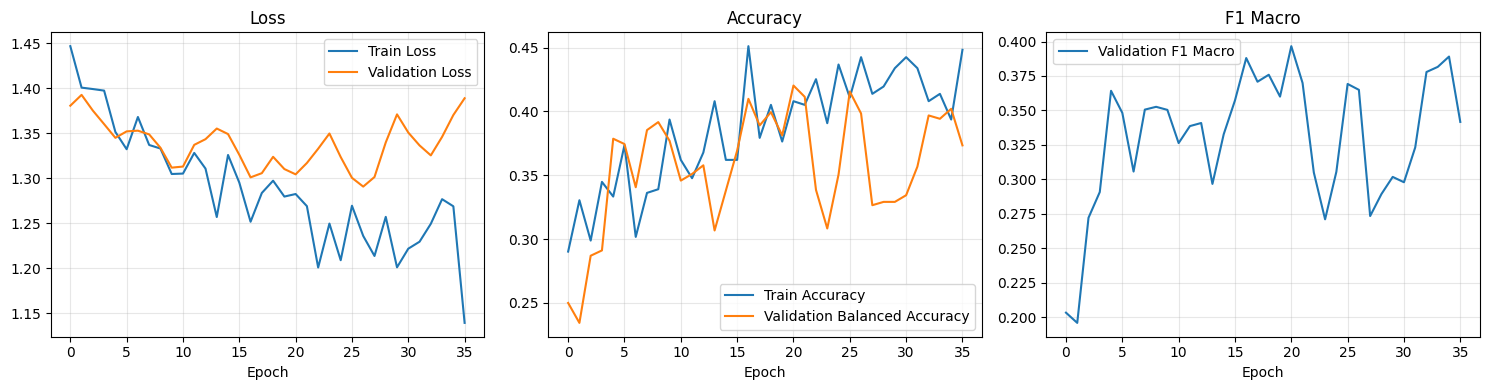

In [29]:
# ============================================================
# CELL 7 - TRAINING CURVES
# ============================================================
plt.figure(figsize=(15, 4))

# --- LOSS ---
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

# --- ACC ---
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_bal_acc'], label='Validation Balanced Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

# --- F1 MACRO ---
plt.subplot(1, 3, 3)
plt.plot(history['val_f1_macro'], label='Validation F1 Macro')
plt.title("F1 Macro")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Loading EfficientNet-B7 weights...
Best model loaded (Ranger, con TTA per eval).

--- CLASSIFICATION REPORT (TTA) ---
              precision    recall  f1-score   support

           0       0.38      0.46      0.42        24
           1       0.41      0.38      0.39        24
           2       0.28      0.22      0.25        32
           3       0.36      0.50      0.42        10

    accuracy                           0.36        90
   macro avg       0.36      0.39      0.37        90
weighted avg       0.35      0.36      0.35        90



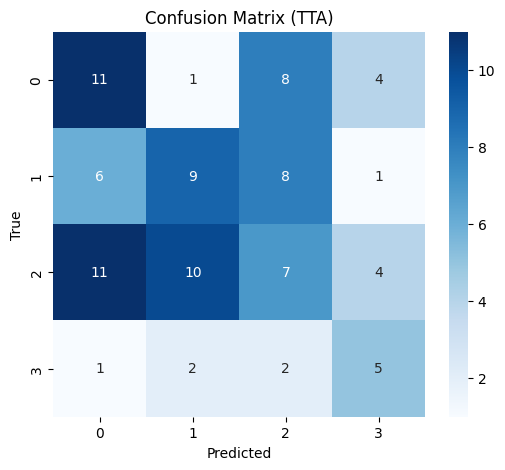

In [30]:
# ============================================================
# CELL 8 - EVALUATION ON VALIDATION SET (con TTA)
# ============================================================

# Load best model
model_eval = get_model()
state_dict = torch.load("/kaggle/working/best_effnet_b7_mask_f1_ranger.pth",
                        map_location=device)

new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace("module.", "")   # rimuovi 'module.' se c'era DataParallel
    new_state_dict[name] = v

model_eval.load_state_dict(new_state_dict)
model_eval = model_eval.to(device)
model_eval.eval()

print("Best model loaded (Ranger, con TTA per eval).")

y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        # inputs: (B,4,H,W), labels: (B,)
        for x, y in zip(inputs, labels):
            x = x.unsqueeze(0)   # (1,4,H,W)
            pred, _ = tta_predict(x, model_eval)
            y_true.append(int(y.item()))
            y_pred.append(int(pred))

# Classification report
print("\n--- CLASSIFICATION REPORT (TTA) ---")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (TTA)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [31]:
# ============================================================
# CELL 9 - INFERENCE ON TEST IMAGES
# ============================================================

# Create test dataset and loader (con maschere)
test_ds = TestDataset(TEST_IMAGES_ROOT, mask_root=TEST_MASKS_ROOT, transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

print(f"Test images found: {len(test_ds)}")

# Generate predictions
predictions = []

model_eval.eval()
with torch.no_grad():
    for inputs, img_names in test_loader:
        # inputs: (1,4,H,W)
        pred, prob = tta_predict(inputs, model_eval)

        img_name = img_names[0]
        predictions.append({
            'sample_index': img_name,
            'label': id2label[int(pred)],
        })

# Save predictions
results_df = pd.DataFrame(predictions)
results_df.to_csv('test_predictions.csv', index=False)
print(f"\nPredictions saved to test_predictions.csv")
print(results_df.head(10))

Test images found: 477

Predictions saved to test_predictions.csv
   sample_index            label
0  img_0000.png        Luminal A
1  img_0001.png        Luminal B
2  img_0002.png        Luminal B
3  img_0003.png  Triple negative
4  img_0004.png        Luminal A
5  img_0005.png          HER2(+)
6  img_0006.png        Luminal A
7  img_0007.png        Luminal A
8  img_0008.png          HER2(+)
9  img_0009.png        Luminal A


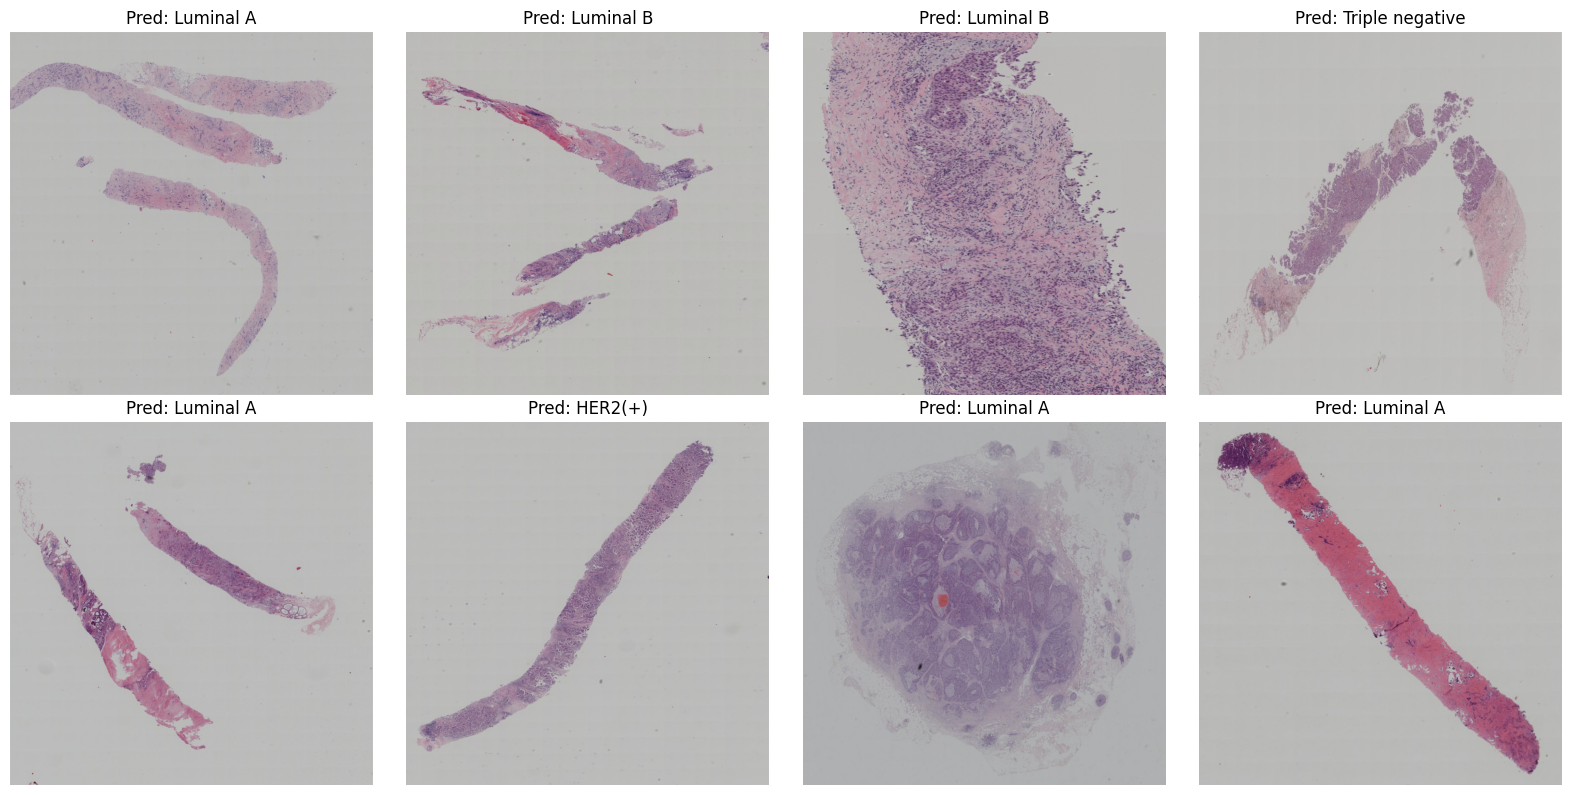

In [32]:
# ============================================================
# CELL 10 - VISUALIZE SOME TEST PREDICTIONS
# ============================================================

# Display some test predictions (solo RGB per visual)
num_show = min(8, len(test_ds))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i in range(num_show):
    img_name = predictions[i]['sample_index']      # <--- nome file
    pred_lab = predictions[i]['label']             # <--- etichetta predetta

    img_path = os.path.join(TEST_IMAGES_ROOT, img_name)
    img = Image.open(img_path).convert("RGB")

    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {pred_lab}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## GRAD-CAM

In [33]:
# ============================================================
# CELL 9 - GRAD-CAM UTILS
# ============================================================
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import torch.nn as nn
import os

# scegli il layer (ultimo blocco conv del backbone)
if isinstance(model_eval, nn.DataParallel):
    target_layer = model_eval.module.features[-1]
else:
    target_layer = model_eval.features[-1]


def gradcam_for_tensor(img_4ch, model, target_layer, target_class=None):
    """
    img_4ch: tensor (1, 4, H, W) già normalizzato
    ritorna: cam (H, W) in [0,1], target_class (int)
    """
    model.eval()
    activations = []
    gradients = []

    def fwd_hook(m, inp, out):
        activations.append(out.detach())

    def bwd_hook(m, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    img_4ch = img_4ch.to(device)

    with torch.enable_grad():
        outputs = model(img_4ch)  # (1, num_classes)
        if target_class is None:
            target_class = outputs.argmax(dim=1).item()
        score = outputs[0, target_class]
        model.zero_grad()
        score.backward()

    acts = activations[0]   # (1, C, h, w)
    grads = gradients[0]    # (1, C, h, w)

    weights = grads.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)
    cam = (weights * acts).sum(dim=1)               # (1, h, w)
    cam = F.relu(cam)[0].cpu().numpy()

    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    h1.remove()
    h2.remove()

    return cam, target_class


def plot_gradcam_for_idx(idx, true_label, pred_label, title_prefix=""):
    """
    idx: indice nel val_ds
    true_label, pred_label: int
    """
    # tensor 4 canali dal dataset già trasformato
    img_4ch, _ = val_ds[idx]
    img_4ch_batch = img_4ch.unsqueeze(0)  # (1,4,H,W)

    # immagine RGB originale per overlay
    row = val_ds.df.iloc[idx]
    img_name = row[IMG_COL]
    img_path = os.path.join(TRAIN_IMAGES_ROOT, img_name)
    orig_rgb = np.array(Image.open(img_path).convert("RGB"))
    H, W, _ = orig_rgb.shape

    cam, target_class = gradcam_for_tensor(
        img_4ch_batch, model_eval, target_layer, target_class=pred_label
    )

    cam_resized = cv2.resize(cam, (W, H))
    heatmap = (cam_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = (0.4 * heatmap + 0.6 * orig_rgb).astype(np.uint8)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(orig_rgb)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(cam_resized, cmap="jet")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title(f"{title_prefix} (y={true_label}, ŷ={pred_label})")
    plt.imshow(overlay)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


CORRECT samples (idx, true, pred): [(5, 2, 2), (7, 1, 1), (9, 0, 0)]
WRONG samples   (idx, true, pred): [(0, 2, 3), (1, 1, 2), (2, 2, 1)]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


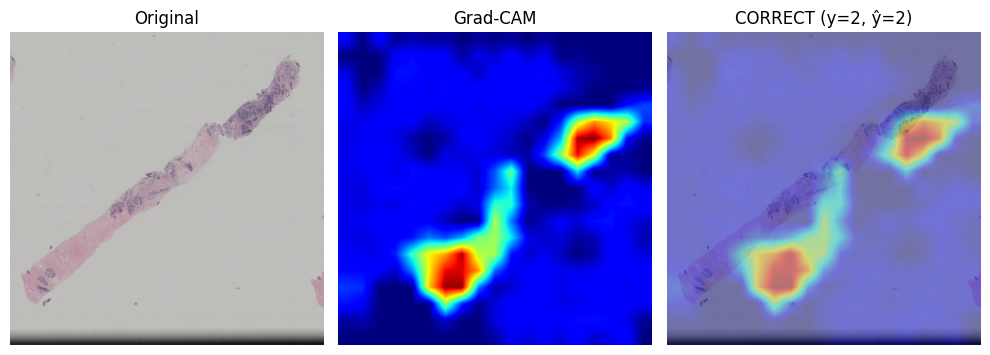

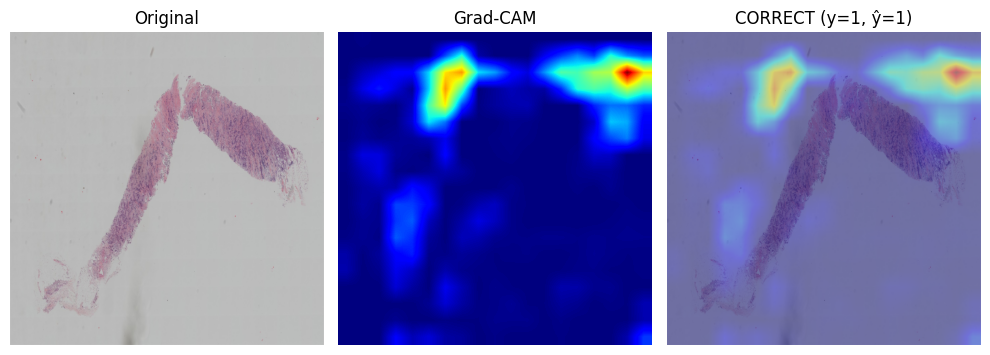

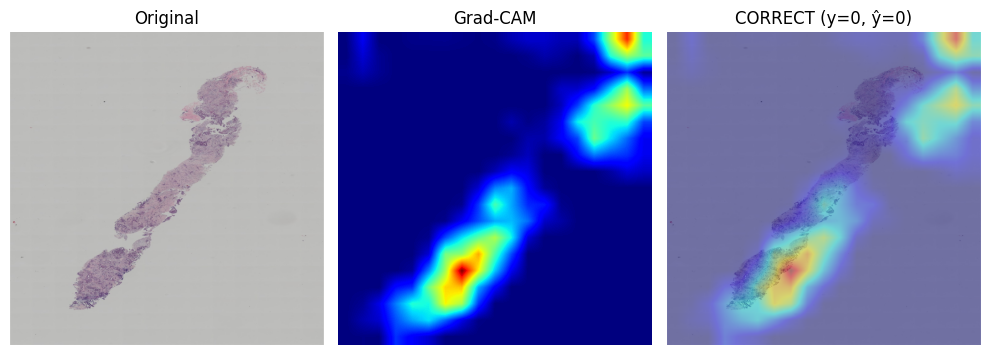

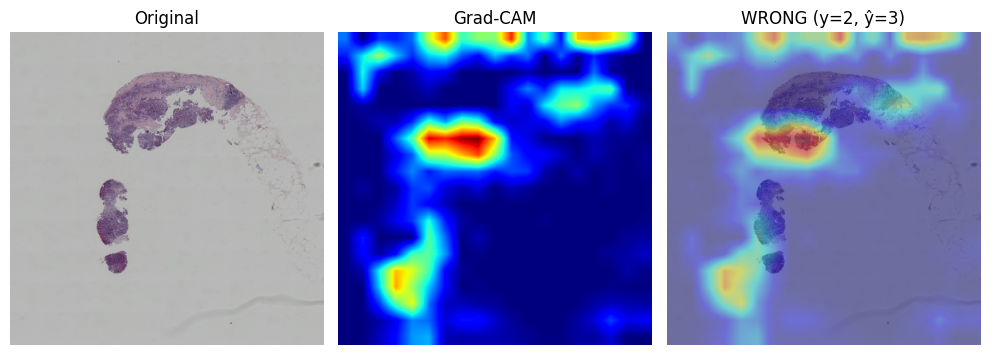

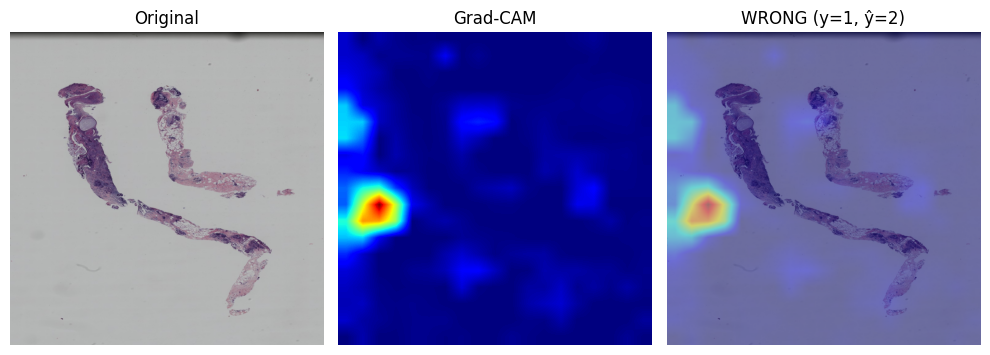

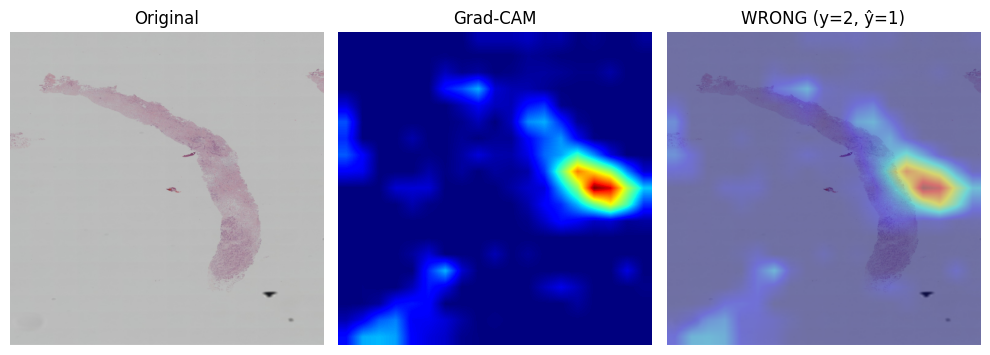

In [34]:
# ============================================================
# CELL 10 - SAMPLES CORRETTI / SBAGLIATI CON GRAD-CAM
# ============================================================

N_CORRECT = 3   # quante predizioni giuste vuoi vedere
N_WRONG   = 3   # quante sbagliate

correct_samples = []   # lista di (idx, true, pred)
wrong_samples   = []

# passata veloce sul validation set per trovare esempi
with torch.no_grad():
    for idx in range(len(val_ds)):
        img_4ch, label = val_ds[idx]
        img_batch = img_4ch.unsqueeze(0).to(device)

        outputs = model_eval(img_batch)
        pred = outputs.argmax(1).item()
        label_int = int(label)

        if pred == label_int and len(correct_samples) < N_CORRECT:
            correct_samples.append((idx, label_int, pred))
        elif pred != label_int and len(wrong_samples) < N_WRONG:
            wrong_samples.append((idx, label_int, pred))

        if len(correct_samples) >= N_CORRECT and len(wrong_samples) >= N_WRONG:
            break

print("CORRECT samples (idx, true, pred):", correct_samples)
print("WRONG samples   (idx, true, pred):", wrong_samples)

# --- Plot Grad-CAM per i corretti ---
for idx, y, yhat in correct_samples:
    plot_gradcam_for_idx(idx, y, yhat, title_prefix="CORRECT")

# --- Plot Grad-CAM per gli sbagliati ---
for idx, y, yhat in wrong_samples:
    plot_gradcam_for_idx(idx, y, yhat, title_prefix="WRONG")
